In [1]:
# imports
import numpy as np
import sympy as sy
import re

import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib.ticker import PercentFormatter
from matplotlib import rcParams
import scipy.constants as pc
from sympy import *
from math import log10, floor
from math import *
import math

from scipy.optimize import curve_fit
from scipy.optimize import minimize

rcParams['font.size'] = 15
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['axes.grid'] = True
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams["xtick.minor.size"] =  4
rcParams["ytick.minor.size"] =  4
rcParams["xtick.minor.visible"] =  True
rcParams["ytick.minor.visible"] =  True

In [2]:
# Funktionen
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def fehlerMax(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += dif * unsicherheiten[i]
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def groessterBeitrag(f, werte, unsicherheiten, variablen):
    zMax = 0
    zMaxArray = np.array([])
    for i in range (werte.size):
        zMax = (np.abs(sy.diff(f, variablen[i])) * unsicherheiten[i])
        for j in range(werte.size):
            zMax = sub(zMax, variablen[j], werte[j])
        x = np.array([zMax])
        zMaxArray = np.append(zMaxArray, x)
    return variablen[np.argmax(zMaxArray)], zMaxArray[np.argmax(zMaxArray)]

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (koeffizienten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def einfachGaussMultMax(unsicherheiten, werte, exponenten):
    max_a = 0
    num = -1
    for i in range (unsicherheiten.size):
        maxi = (exponenten[i]*unsicherheiten[i]/werte[i])**2
        if max_a <= maxi:
            max_a = maxi
            num = i
    return (max_a, num)

def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

def bestA(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

def bestB(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestA(x, y)+bestB(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

def stuA(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

def round_to_j(x,j):
    return round(x, (j-1)-int(floor(log10(abs(x)))))

def print_to_table(avgs, stds, rows, cols,
                   highlight_best=True,
                   max_is_best=True,
                   avg_format='{0:!>4.1f}',
                   std_format='{1:!<4.1f}',
                   file=None,
                   col_orientation='c'):
    # Find best values
    best_avg = {}
    if highlight_best:
        if max_is_best:
            for c in cols:
                idx = np.argmax(avgs[c], axis=0)
                best_avg[c] = idx
        else:
            for c in cols:
                idx = np.argmin(avgs[c], axis=0)
                best_avg[c] = idx

    # Header
    print_str = '\\begin{tabular}{l' + (" "+col_orientation) * len(cols) + '} \hline\n'
    for c in cols:
        print_str += ' & ' + c
    print_str += ' \\\\ \n \hline'

    # Content
    for m in range(len(rows)):
        row_name = rows[m]
        print_str += '\n{0}'.format(row_name)
        for c in cols:
            print_str += ' &\n '
            print_list = [avgs[c][m]]
            print_list += [stds[c][m]]
            if m == best_avg.get(c, None):
                print_str += ('$\mathbf{{'+ avg_format + ' \\pm ' + std_format + '}}$').format(*print_list)
            else:
                print_str += ('$'+ avg_format + ' \\pm ' + std_format + '$').format(*print_list)

        print_str += "\n \\vspace*{0.0mm} \\\\"
        print_str = print_str.replace('!', '\\phantom{0}')

    # Footer
    print_str += '\n \hline \n \end{tabular}'

    # Write output
    if file is None:
        print(print_str)
    else:
        with open(file, 'w') as f:
            f.write(print_str)

In [3]:
#numerische Minimierung; parameterFinden(); Programm hängt sich nicht auf, dauert nur ordentlich lange

'''def chiQuadrat(xWerte, yWerte, funktion):
    #print(xWerte)
    #print(yWerte)
    #print(funktion)
    chiQ = 0
    unsich = std(yWerte)
    for i in range(xWerte.size):
        mp = sub(funktion, x, xWerte[i])
        #print(mp)
        chiQ += (yWerte[i]-mp)**2/unsich**2
        #print(chiQ)
    return chiQ'''

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])


def chiQuadrat(xWerte, yWerte, yUnsicherheit, funktion):
    chiQ = 0
    for i in range(xWerte.size):
        mp = sub(funktion, x, xWerte[i])
        chiQ += (yWerte[i]-mp)**2/(yUnsicherheit[i])**2
    return chiQ


def comb(a,b):
    c = np.array([[a[0],b[0]]])
    for i in a:
        for j in b:
            if (j != b[0] and i!=a[0]):
                c = np.concatenate((c,np.array([[i,j]])),axis=0)
    return c


def numMinChiQuadrat(parameter, xWerte, yWerte, yUnsicherheit, funktion, paramedics):#parameter:array;xWerte:array;yWerte:array;yUnsicherheiten:array,funktion:function;paramedics:array von arrays
    numMin = 200000
    bestpara = np.empty(parameter.size,dtype=float)
    tupel = paramedics[0]

    for b in range(parameter.size):
        if b!=0:
            tupel = comb(tupel,paramedics[b])
    for combi in tupel:
        funktioni = funktion
        for para in range(combi.size):
            funktioni = sub(funktioni,parameter[para],combi[para])
            
        vergleich = chiQuadrat(xWerte, yWerte, yUnsicherheit, funktioni)
        if np.array_equal(combi,tupel[0]):
            numMin = vergleich
            bestpara = combi
        if vergleich<numMin:
            numMin = vergleich
            bestpara = combi
    return bestpara, numMin


def parameterFinden(parameter,     #Symbols als array
                    xWerte,        #xWerte als array
                    yWerte,        #yWerte als array
                    yUnsicherheit, #yUnsicherheiten als array
                    funktion,      #funktion aus ParameterSymbols, mit xSymbol
                    bereiche,      #bereiche als array von arrays mit Höchst- und Tiefswerte in selber Reihenfolge wie die parameter. !!Bereiche möglichst gut schätzen!! Sonst ist chiquadrat evtl verfälscht.
                    tiefe):        #Größenordnung wir genau. Eins höher, 1 Zehntel kleinerer Bereich, !!exponentieller Anstieg der Dauer!! 3 oder 4 reicht meist aus.
    while(tiefe>0):
        genau = 20*tiefe
        bereich = np.array([np.linspace(bereiche[0][0],bereiche[0][1],genau)])
        for i in range(parameter.size):
            if i != 0:
                bereich = np.concatenate((bereich,np.array([np.linspace(bereiche[i][0],bereiche[i][1],genau)])),axis=0)
        bestpara, numMin = numMinChiQuadrat(parameter, xWerte, yWerte, yUnsicherheit, funktion, bereich)
        for i in range(parameter.size):
            for j in range(genau):
                if bestpara[i] == bereich[i][j]:
                    bereiche[i][0] = (bereich[i][j]-np.abs((bereiche[i][1]-bereiche[i][0])/(genau*1.5)))
                    bereiche[i][1] = (bereich[i][j]+np.abs((bereiche[i][1]-bereiche[i][0])/(genau*1.5)))
        tiefe -=1
    return bestpara, numMin

In [4]:
#
# Erinnerungen
#

#ax.plot(x, y, color='tab:bue', label=r'label')
#ax.scatter(x, y, color='tab:red', label=r'label')
#ax.errorbar(am_x, am_y, xerr=std_x, yerr=std_y, capsize='5', 
#            ecolor=['tab:blue','tab:red'], fmt='none', color='tab:blue', label=r'label')
# x = np.array([,])
# x.size
# x, y = symbols('x y')
# expr = x*y
# expr.subs([(x, wert_x), (y, wert_y)])

In [5]:
dataBG = np.delete(np.loadtxt("BG_3h.txt", dtype='int'), [0, 1])/6

dataSodium = np.delete(np.loadtxt("Natrium22.txt", dtype='int'), [0, 1]) - dataBG
dataCobalt = np.delete(np.loadtxt("Cobalt60.txt", dtype='int'), [0, 1]) - dataBG
dataEuropium = np.delete(np.loadtxt("Europium152.txt", dtype='int'), [0, 1]) - dataBG

dataNAN = np.delete(np.loadtxt("NAN.txt", dtype='int'), [0, 1]) #- dataBG

dataSodium[dataSodium < 0] = 0
dataCobalt[dataCobalt < 0] = 0
dataEuropium[dataEuropium < 0] = 0

nBins = len(dataSodium)
bins = np.arange(0, nBins, 1)
maxE = 2785
secondAxisTicks = np.arange(0, nBins, nBins/20)
binsE = (secondAxisTicks*maxE/nBins).astype(int)

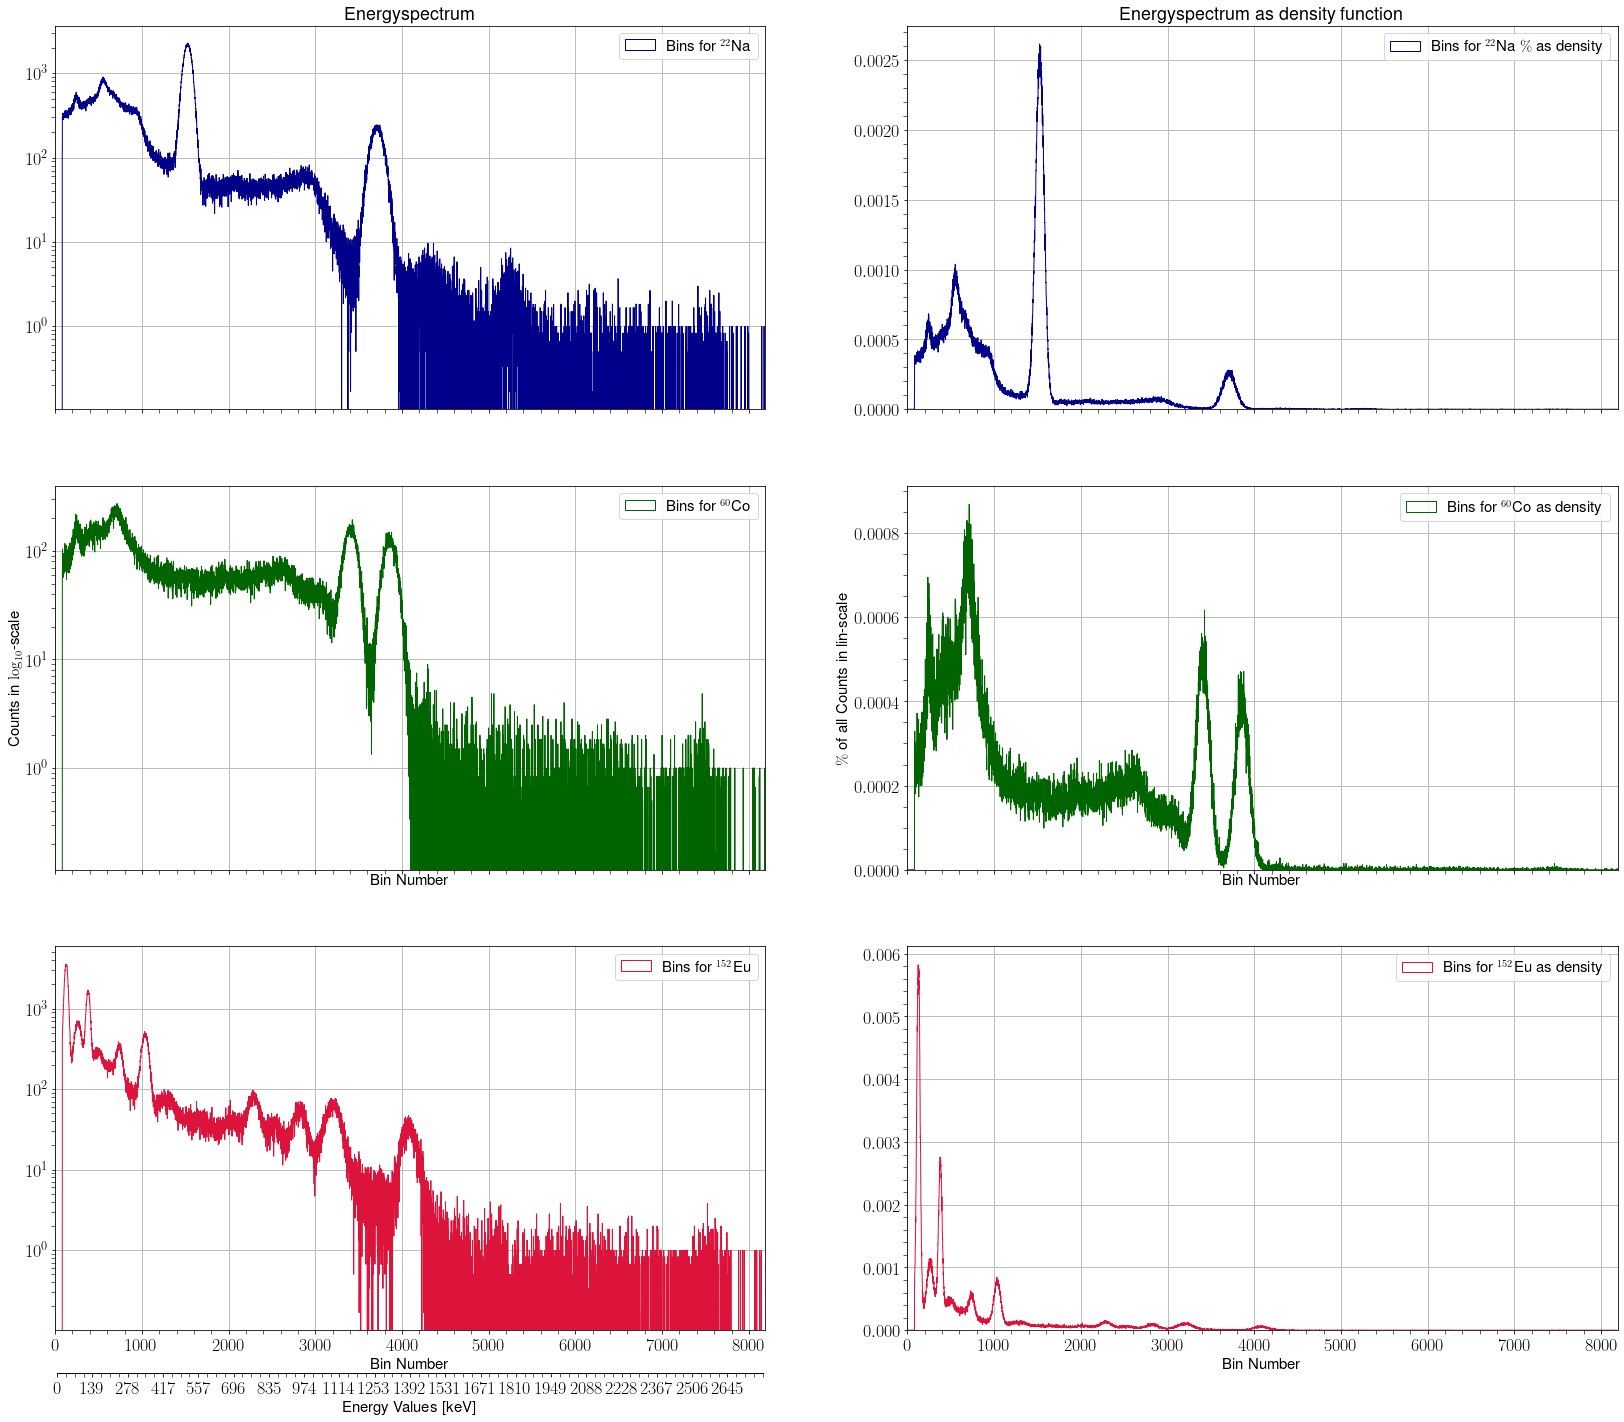

In [6]:
# Standard plotting

fig, ax = plt.subplots(3, 2, sharex=True, figsize=(28,24))

#x = np.array([])
#dataSodium, nBins = np.histogram(x)
#ax[0].stairs(counts, bins)

ax[0 ,0].hist(bins, bins=nBins, histtype='step', color='darkblue', 
           weights=dataSodium, label=r'Bins for $^{22}$Na')

#ax[0].errorbar(bins, dataSodium, yerr=np.sqrt(dataSodium), capsize=.3, elinewidth=.2, fmt='none', color="black")

ax[1 ,0].hist(bins, bins=nBins, histtype='step', color='darkgreen', 
           weights=dataCobalt, label=r'Bins for $^{60}$Co')

ax[2, 0].hist(bins, bins=nBins, histtype='step', color='crimson', 
           weights=dataEuropium, label=r'Bins for $^{152}$Eu')

# Normalized
ax[0,1].hist(bins, bins=nBins, histtype='step', color='darkblue', weights=dataSodium, 
           label=r'Bins for $^{22}$Na $\%$ as density', density=True)

ax[1 ,1].hist(bins, bins=nBins, histtype='step', color='darkgreen', 
           weights=dataCobalt, label=r'Bins for $^{60}$Co as density', density=True)

ax[2, 1].hist(bins, bins=nBins, histtype='step', color='crimson', 
           weights=dataEuropium, label=r'Bins for $^{152}$Eu as density', density=True)


## create second Axes. Note the 0.0 height
secondXAxis = fig.add_axes((.126,.1,.35,.0))
secondXAxis.yaxis.set_visible(False) # hide the yaxis


secondXAxis.set_xticks(secondAxisTicks)
secondXAxis.set_xticklabels(np.char.add(np.char.add('$', binsE.astype(str)),'$'))
secondXAxis.set_xlabel(r"Energy Values [keV]")

# Now we format the y-axis to display percentage
# ax[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.xlim(0, nBins)
ax[0, 0].set_xlim([0, nBins])
ax[0, 0].set_yscale('log')
ax[1, 0].set_yscale('log')
ax[2, 0].set_yscale('log')

ax[0, 0].set(title=r'Energyspectrum')
ax[1, 0].set(xlabel=r'Bin  Number', ylabel=r'Counts in $\log_{10}$-scale')
ax[2, 0].set(xlabel=r'Bin  Number')
ax[0, 1].set(title=r'Energyspectrum as density function')
ax[1, 1].set(xlabel=r'Bin  Number', ylabel=r'$\%$ of all Counts in lin-scale')
ax[2, 1].set(xlabel=r'Bin  Number')


ax[0, 0].legend()
ax[1, 0].legend()
ax[2, 0].legend()
ax[0, 1].legend()
ax[1, 1].legend()
ax[2, 1].legend()


fig.savefig("HistogramsWithoutBackground.svg")

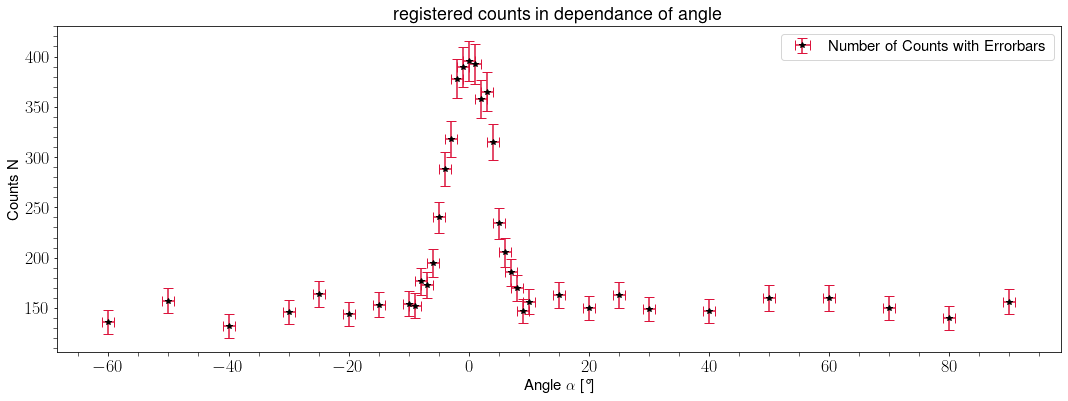

In [7]:
# Part two

fig, ax = plt.subplots(figsize=(18,6))

angles = np.array([-60, -50, -40, -30, -25, -20, -15, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 
                   0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90])
counts = np.array([136, 157, 132, 146, 164, 144, 153, 
                   (146+162)/2, (147+157)/2, (181+172)/2, (177+168)/2, (200+189)/2, 
                   (239+241)/2, (293+283)/2, (329+307)/2, (388+368)/2, (387+392)/2,
                   (408+383)/2, 
                   (389+396)/2, (338+378)/2, (350+380)/2, (302+328)/2, (233+235)/2, 
                   (186+225)/2, (171+200)/2, (161+179)/2, (130+164)/2, (154+158)/2, 
                   163, 150, 163, 149, 147, 160, 160, 150, 140, 156])

ax.errorbar(angles, counts, xerr=1, yerr=np.sqrt(counts), capsize=5, 
            ecolor='crimson', fmt='*', color='black', label=r'Number of Counts with Errorbars')

ax.set(xlabel=r'Angle $\alpha$ [°]', ylabel=r'Counts N', title=r'registered counts in dependance of angle')
ax.legend()
ax.grid()

#fig.savefig("Part2.svg")

In [8]:
# print(dataSodium)
# print(dataCobalt)
# print(dataEuropium)

def peak_define(original_data,lower_bound,upper_bound):
    upper_cutoff = len(original_data)-upper_bound
    print(upper_cutoff)
    return bins[lower_bound:-upper_cutoff],original_data[lower_bound:-upper_cutoff]

6540
4260


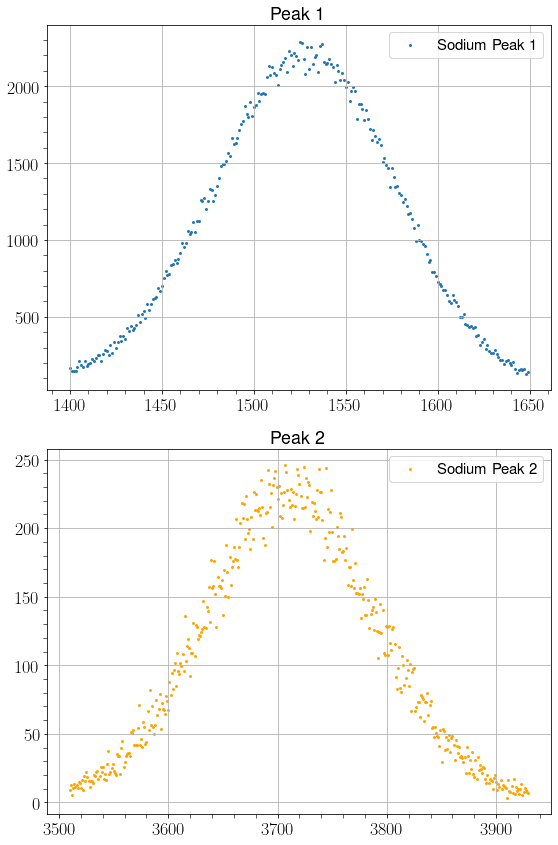

In [9]:
#SODIUM

bins_na_peak_1,na_peak_1 = peak_define(dataSodium,1400,1650)

bins_na_peak_2,na_peak_2 = peak_define(dataSodium,3510,3930)

# Create a figure and divide it into subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

# Plot data on each subplot
axes[0].scatter(bins_na_peak_1, na_peak_1, label='Sodium Peak 1', marker='.',s=15)
axes[0].set_title('Peak 1')
axes[0].legend()

axes[1].scatter(bins_na_peak_2, na_peak_2, label='Sodium Peak 2', color='orange',marker='.',s=15)
axes[1].set_title('Peak 2')
axes[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [15]:
# Define the function you want to fit
def my_function(x, A, sigma, mu):
    return A / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

# Define the chi-squared function
def chi_squared(params, x, y, errors):
    model = my_function(x, *params)
    residuals = (y - model) / errors
    return np.sum(residuals**2)

def least_square_fit(x_data,y_data,initial_guess,):

    errors = np.sqrt(y_data)



#initial_guess = [290000, 70, 1500]



# Minimize the chi-squared function
    result = minimize(chi_squared, initial_guess, args=(x_data, y_data, errors))

# Extract the fitted parameters and the minimized chi-squared value
    fit_params = result.x
    min_chi_squared = result.fun

# Print the fitted parameters and the minimized chi-squared value
    print("Fitted Parameters:", fit_params)
    print("Minimized Chi-squared:", min_chi_squared)
    
    return (x_data,y_data,fit_params,errors)
    
# Plot the original data and the fitted curve
# plt.errorbar(x_data, y_data, yerr=0, fmt='.', label="Data")
# plt.plot(x_data, my_function(x_data, *fit_params), label="Fitted Curve", color='orange')
# plt.legend()
# plt.show()

Fitted Parameters: [2.80728898e+05 5.12730388e+01 1.52646301e+03]
Minimized Chi-squared: 584.0051699105611
Fitted Parameters: [44051.13879222    78.9234626   3711.9392892 ]
Minimized Chi-squared: 496.8086795112685


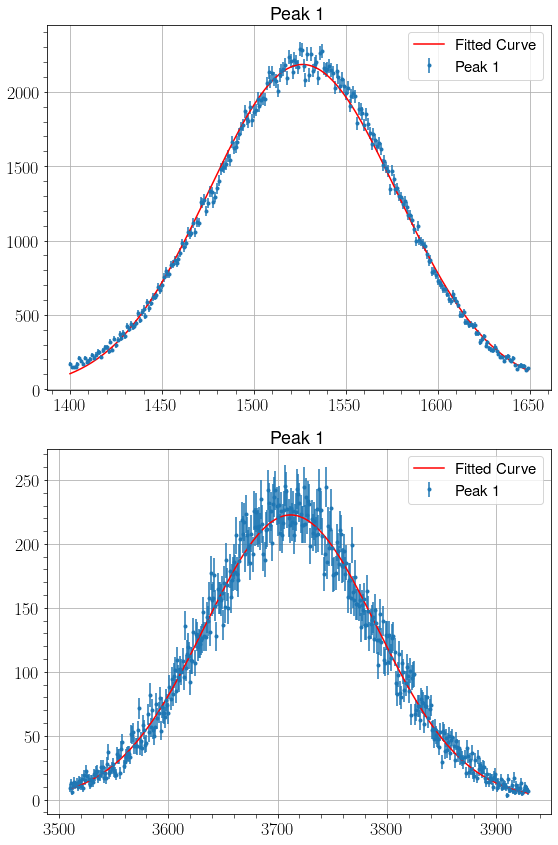

In [22]:
#SODIUM FIT

na_least_sqaure_fit_p1 = least_square_fit(bins_na_peak_1,na_peak_1,[290000, 70, 1500])
na_least_sqaure_fit_p2 = least_square_fit(bins_na_peak_2,na_peak_2,[50000, 70, 3700])


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

# Peak 1 Plotting
axes[0].errorbar(na_least_sqaure_fit_p1[0], na_least_sqaure_fit_p1[1],
             yerr=na_least_sqaure_fit_p1[3], fmt='.', label="Peak 1")
axes[0].plot(na_least_sqaure_fit_p1[0], my_function(na_least_sqaure_fit_p1[0],
            *na_least_sqaure_fit_p1[2]), label="Fitted Curve", color='r')
axes[0].set_title('Peak 1')
axes[0].legend()

# Peak 2 Plotting
axes[1].errorbar(na_least_sqaure_fit_p2[0], na_least_sqaure_fit_p2[1],
             yerr=na_least_sqaure_fit_p2[3], fmt='.', label="Peak 1")
axes[1].plot(na_least_sqaure_fit_p2[0], my_function(na_least_sqaure_fit_p2[0],
            *na_least_sqaure_fit_p2[2]), label="Fitted Curve", color='r')
axes[1].set_title('Peak 1')
axes[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
#SODIUM DELETED VALUES

bins_na_peak_1,na_peak_1 = peak_define(dataSodium,1400,1650)
bins_na_peak_1 = np.concatenate((bins_na_peak_1[:100], bins_na_peak_1[155+1:]))
na_peak_1 = np.concatenate((na_peak_1[:100], na_peak_1[155+1:]))

bins_na_peak_2,na_peak_2 = peak_define(dataSodium,3510,3930)

# Create a figure and divide it into subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

# Plot data on each subplot
axes[0].scatter(bins_na_peak_1, na_peak_1, label='Sodium Peak 1', marker='.',s=15)
axes[0].set_title('Peak 1')
axes[0].legend()

axes[1].scatter(bins_na_peak_2, na_peak_2, label='Sodium Peak 2', color='orange',marker='.',s=15)
axes[1].set_title('Peak 2')
axes[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
# Define the function you want to fit
def my_function(x, A, sigma, mu):
    return A / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

# Define the chi-squared function
def chi_squared(params, x, y, errors):
    model = my_function(x, *params)
    residuals = (y - model) / errors
    return np.sum(residuals**2)


# Generate example data with errors
x_data = bins_na_peak_1
y_data = na_peak_1
errors = np.sqrt(y_data)

# Define an initial guess for the parameters

initial_guess = [290000, 70, 1500]



# Minimize the chi-squared function
result = minimize(chi_squared, initial_guess, args=(x_data, y_data, errors))

# Extract the fitted parameters and the minimized chi-squared value
fit_params = result.x
min_chi_squared = result.fun

# Print the fitted parameters and the minimized chi-squared value
print("Fitted Parameters:", fit_params)
print("Minimized Chi-squared:", min_chi_squared)

# Plot the original data and the fitted curve
plt.errorbar(x_data, y_data, yerr=0, fmt='.', label="Data")
plt.plot(x_data, my_function(x_data, *fit_params), label="Fitted Curve", color='orange')
plt.legend()
plt.show()